In [1]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns

plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams['grid.color'] = '#505F69'
sns.set_style("whitegrid")

In [2]:
# read data
cdc = pd.read_csv('cdc.csv', skiprows=2)

# rename some CDC columns
cdc.rename(columns={
    'abbr': 'state',
    'Total Cases': 'cdc_total_cases',
    'Total Death': 'cdc_total_death',
    'CasesInLast7Days': 'cdc_cases_last_7_days',
    'RatePer100000': 'cdc_rate_per_100000',
    'Total Tests Performed': 'cdc_total_tests',
    'Percent Positive Range': 'cdc_percent_positive_range',
    'cumulative_positive_tests': 'cdc_cumulative_positive_tests'
}, inplace=True)

In [3]:
# Use CTP 5/14 for comparing test counts

ctp_514_tests = pd.read_csv('ctp_514.csv')
ctp_514_test_overrides = pd.read_csv('ctp_514_specimen_tests.csv')

ctp_514_merged_df = pd.merge(
    ctp_514_tests, ctp_514_test_overrides, on=['state', 'date'], how='inner', sort=True, copy=True)

def pick_total_tests_for_analysis(row):
    # if total tests specimens is present, use that. otherwise, use total tests people
    return row.total_tests_specimens if not pd.isnull(row.total_tests_specimens) else row.total_tests_people

ctp_514_merged_df['ctp_total_tests_for_analysis'] = ctp_514_merged_df.apply(pick_total_tests_for_analysis, axis=1)

# merge with CTP reported data - only keeping rows for which both CDC and CTP report data
merged_df_test_counts = pd.merge(
    cdc, ctp_514_merged_df, on=['state', 'fips'], how='inner', sort=True, copy=True)

# of this, keep only some interesting columns:
# state, jurisdiction, cdc_total_cases, cdc_total_death, cdc_total_tests
cols_to_keep = ['state', 'jurisdiction', 'cdc_total_cases', 'cdc_total_death', 'cdc_total_tests',
               'ctp_total_tests_for_analysis']
merged_df_test_counts = merged_df_test_counts[cols_to_keep]
merged_df_test_counts.head()

,state,jurisdiction,cdc_total_cases,cdc_total_death,cdc_total_tests,ctp_total_tests_for_analysis
0,AK,Alaska,388,10,46589.0,31762.0
1,AL,Alabama,11642,484,168687.0,141985.0
2,AR,Arkansas,4463,98,84496.0,75818.0
3,AZ,Arizona,13169,651,210388.0,134338.0
4,CA,California,74936,3108,924696.0,1104651.0


In [4]:
# will use CTP 5/16 for comparing positives/deaths
ctp_516_positives_deaths = pd.read_csv('ctp_516.csv')
cols_to_keep = ['state', 'positive', 'death']
ctp_516_positives_deaths = ctp_516_positives_deaths[cols_to_keep]
ctp_516_positives_deaths.head()

,state,positive,death
0,AK,392.0,10.0
1,AL,11523.0,485.0
2,AR,4578.0,98.0
3,AZ,13631.0,679.0
4,CA,76793.0,3204.0


# Make a minimal dataframe for analysis containing only final columns

In [5]:
full_merged_df = pd.merge(
    merged_df_test_counts, ctp_516_positives_deaths, on=['state'], how='inner', sort=True, copy=True)
# rename some CDC columns
full_merged_df.rename(columns={
    'positive': 'ctp_total_cases',
    'death': 'ctp_total_death',
}, inplace=True)
full_merged_df.set_index('state', inplace=True)
full_merged_df.to_csv('merged_data_for_analysis.csv')

In [6]:
full_merged_df['test_count_diff'] = \
    full_merged_df['cdc_total_tests'] - full_merged_df['ctp_total_tests_for_analysis']
full_merged_df['abs_test_count_diff'] = \
    abs(full_merged_df['cdc_total_tests'] - full_merged_df['ctp_total_tests_for_analysis'])
full_merged_df['test_count_percent_diff'] = \
    full_merged_df['test_count_diff']/full_merged_df['ctp_total_tests_for_analysis']
full_merged_df['abs_test_count_percent_diff'] = \
    abs(full_merged_df['test_count_diff']/full_merged_df['ctp_total_tests_for_analysis'])
# sort by test_count_diff
full_merged_df.sort_values('test_count_diff', inplace=True)

In [7]:
import matplotlib.image as mpimg
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
logo = mpimg.imread('logo.png')

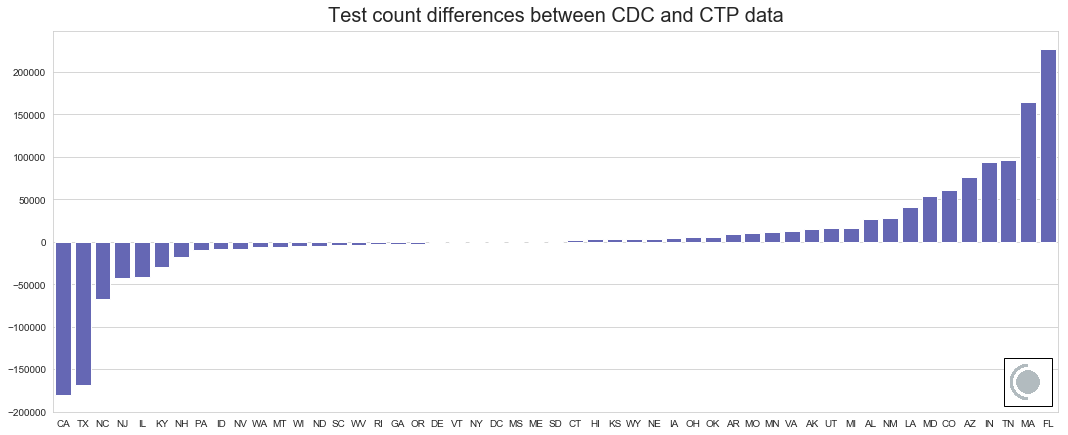

In [8]:
sns.set_style("whitegrid")

plt.figure(figsize=(18,7))

ax = sns.barplot(x=full_merged_df.index, y='test_count_diff', data=full_merged_df, color='#585bc1')
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('Test count differences between CDC and CTP data', fontsize=20, pad=10)

imagebox = OffsetImage(logo, zoom=0.08)
ab = AnnotationBbox(imagebox, (48.0, 40.0), box_alignment=(0, 4.0))
ax.add_artist(ab)

plt.savefig("test_count_differences.svg")

In [9]:
# how close is our data to CDC?

print('Within 1000: %d states' % sum(
    full_merged_df.apply(lambda row: abs(row.test_count_diff) < 1000, axis=1)))
print('Within 10 percent: %d states' % sum(
    full_merged_df.apply(lambda row: abs(row.test_count_percent_diff) < 0.1, axis=1)))
print('Within 20 percent: %d states' % sum(
    full_merged_df.apply(lambda row: abs(row.test_count_percent_diff) < 0.2, axis=1)))
print('Within 30 percent: %d states' % sum(
    full_merged_df.apply(lambda row: abs(row.test_count_percent_diff) < 0.3, axis=1)))
print('Over 25 percent: %d states' % sum(
    full_merged_df.apply(lambda row: abs(row.test_count_percent_diff) > 0.25, axis=1)))

Within 1000: 5 states
Within 10 percent: 29 states
Within 20 percent: 35 states
Within 30 percent: 41 states
Over 25 percent: 13 states


# What are the most divergent states, by test counts?

In [10]:
# Most divergent states by test counts
for i, row in full_merged_df.sort_values('abs_test_count_diff', ascending=False).head(10).iterrows():
    print('%s: %d CDC, %d CTP tests' % (row.jurisdiction, row.cdc_total_tests, row.ctp_total_tests_for_analysis))

Florida: 919109 CDC, 691653 CTP tests
California: 924696 CDC, 1104651 CTP tests
Texas: 454133 CDC, 623284 CTP tests
Massachusetts: 574645 CDC, 410032 CTP tests
Tennessee: 398173 CDC, 302317 CTP tests
Indiana: 253619 CDC, 160239 CTP tests
Arizona: 210388 CDC, 134338 CTP tests
North Carolina: 151449 CDC, 219268 CTP tests
Colorado: 173626 CDC, 112505 CTP tests
Maryland: 232086 CDC, 178454 CTP tests


# Same thing but by percentage difference?

In [11]:
# Most divergent states by % difference in test counts
for i, row in full_merged_df.sort_values('abs_test_count_percent_diff', ascending=False).head(10).iterrows():
    print('%s: %d CDC, %d CTP tests, %d percent difference' % (
        row.jurisdiction, row.cdc_total_tests, row.ctp_total_tests_for_analysis,
        row.abs_test_count_percent_diff * 100))

Indiana: 253619 CDC, 160239 CTP tests, 58 percent difference
Arizona: 210388 CDC, 134338 CTP tests, 56 percent difference
Colorado: 173626 CDC, 112505 CTP tests, 54 percent difference
New Hampshire: 19450 CDC, 37739 CTP tests, 48 percent difference
Alaska: 46589 CDC, 31762 CTP tests, 46 percent difference
Massachusetts: 574645 CDC, 410032 CTP tests, 40 percent difference
Florida: 919109 CDC, 691653 CTP tests, 32 percent difference
Tennessee: 398173 CDC, 302317 CTP tests, 31 percent difference
North Carolina: 151449 CDC, 219268 CTP tests, 30 percent difference
Maryland: 232086 CDC, 178454 CTP tests, 30 percent difference


# Correlation between CTP and CDC data: tests, positives, deaths

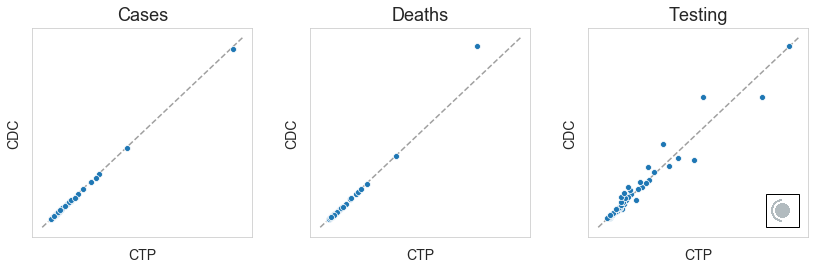

In [12]:
# plot all 3 together

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
fig.tight_layout(pad=3.0)

def plot_gray_yx(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0, linestyle='--', color='gray')
    
    # remove gridlines!
    ax.grid(False)

# Case counts

ax=axes[0]
sns.scatterplot(x='ctp_total_cases', y='cdc_total_cases', data=full_merged_df, ax=ax)
ax.set_ylabel('CDC', fontsize=14)
ax.set_xlabel('CTP', fontsize=14)
ax.set_xticklabels('')
ax.set_yticklabels('')
ax.set_title('Cases', fontsize=18, pad=8)
plot_gray_yx(ax)

# Death counts

ax = axes[1]
sns.scatterplot(x='ctp_total_death', y='cdc_total_death', data=full_merged_df, ax=ax)
ax.set_ylabel('CDC', fontsize=14)
ax.set_xlabel('CTP', fontsize=14)
ax.set_xticklabels('')
ax.set_yticklabels('')
ax.set_title('Deaths', fontsize=18, pad=8)
plot_gray_yx(ax)

# Testing counts

ax = axes[2]
sns.scatterplot(x='ctp_total_tests_for_analysis', y='cdc_total_tests', data=full_merged_df, ax=ax)
ax.set_ylabel('CDC', fontsize=14)
ax.set_xlabel('CTP', fontsize=14)
ax.set_xticklabels('')
ax.set_yticklabels('')
ax.set_title('Testing', fontsize=18, pad=8)
plot_gray_yx(ax)

imagebox = OffsetImage(logo, zoom=0.05)
ab = AnnotationBbox(imagebox, (0, 0), box_alignment=(-6.6, 0.1))
ax.add_artist(ab)

plt.savefig("cases_deaths_testing_scatterplots.svg")